In [1]:
import numpy as np
import pandas as pd
import torch
import spacy
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
import matplotlib
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

In [2]:
# Wrap cos similarity, because it can differ in some interpretation as cos_sim or 1-cos_sim 
def cos_sim(vec1, vec2, sim=1):
    if sim:
        return 1 - cosine(vec1, vec2)
    else:
        return cosine(vec1, vec2)

In [ ]:
# Function to reformat Course_429_user_responses Data. Maybe useful.
def format_data(cell):
    if pd.isnull(cell):
        return np.NaN
    cell = list(filter(None, cell.replace('|',"").strip().replace('❌','|0 ').replace('✅','|1 ').split('|')))
    
    if cell[0].isdigit():
        cell.pop(0)
        
    data = [{'label':s[0] , 'value': s[1:].strip()} for s in cell ]
    return data
"""
data = pd.DataFrame({"Step_prompt": data["Step prompt"],
                     "St_resp1": data["Response 1"].map(format_data),
                     "St_resp2": data["Response 2"].map(format_data),
                     "St_resp3": data["Response 3"].map(format_data),
                     "St_resp4": data["Response 4"].map(format_data),
                     "St_resp5": data["Response 5"].map(format_data),
                     "Pr_resp1": data["Responses 1"].map(format_data),
                     "Pr_resp2": data["Responses 2"].map(format_data),
                     "Pr_resp3": data["Responses 3"].map(format_data),
                     "Pr_resp4": data["Responses 4"].map(format_data),
                     "Pr_resp5": data["Responses 5"].map(format_data),
                     "Unique_ans": data["Unique answers"].map(format_data)
                    })
"""

# Makes Question answer data from full_data
def make_qa_data():
    question = []
    answer = []
    labels = []
    for idx in range(full_data.shape[0]):
        for i in full_data.iloc[idx].dropna():
            #question.append(full_data.iloc[idx].dropna().Step_prompt)
            if type(i) == list:
                for d in i:
                    question.append(full_data.iloc[idx].dropna().Step_prompt)
                    answer.append(d['value'])
                    labels.append(d['label'])
    labels = np.array(labels).astype(float)
    data_dict = {"question":question, "answer":answer, "labels":labels}
    return pd.DataFrame(data_dict)

In [200]:
# Functions to print image
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.3, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    
    # 'top', 'bottom', 'center', 'baseline', 'center_baseline'

    #plt.setp(ax.get_yticklabels(), rotation=0, va="top",rotation_mode="anchor")
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.3f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def print_heatmap(sim_matrix, tokens1, tokens2, size=12, ax=ax):
    #fig, ax = plt.subplots()
    im, cbar = heatmap(sim_matrix, tokens1, tokens2, ax=ax,
                       cmap="YlGnBu", cbarlabel="Answers similarity")
    annotate_heatmap(im, valfmt="{x:.3f}", size=size)
    return fig, ax

## Data wrangling

For experiment we use data from the file **"Course_429_user_responses"**. I converted it in pandas format, made some cleaning and reformating.

For expriments on sematic similarity we use just a part of it, concretely rows **[3,10,17,18,19,25,27]** (they are marked by yellow in the initial document).


In [4]:
# Load data.
# Formatted full data
full_data = pd.read_pickle("Course_429_user_responses_full.pkl")
# Data for training question answering
qua_data = pd.read_pickle("Course_429_user_responses_QuA.pkl")
# Formatted evaluation data with [3,10,17,18,19,25,27] rows
eval_data = pd.read_pickle("Course_429_user_responses_eval.pkl")
# We need to create data for parahprase task
# paraph_data

## Spacy
Spacy is on of the best lightwet NLP frameworks at the moment. It combines traditional language tools like gramatical sentences parsing, named enteties and POS. Also it easily allows to wrap models from Tensorflow, Pytorch, and what is very important Transformers based. Thus, we can train the model in Tensorflow and use it in Spacy, or we can wrap it and train using Spacy pipelines.

For our experiments we downloaded the following models:

* en_core_web_sm (without vwctors)
* en_core_web_md (with vectors)
* en_core_web_lg (with vectors)
* en_vectors_web_log (unknown)
* en_trf_bertbaseuncased_lg (transformer based)

Somtimes it can be usefull to know what kind of enteties some text have.
Let's see haw Spacy does it.
Take some text from our corpus.

```
Back in 2002, the FASB and IASB started to do something that you never see happen between competitors in the free market unless there's a merger. What do you think happened?Massive public companies, like Amazon, can have over 500,000 employees, which gives them plenty of manpower to stay compliant with financial regulations like GAAP or IFRS. Their corporate accounting team alone can have over a 1,000 employees. Smaller nonpublic companies, known as small or medium-sized entities (SMEs), are not held to the same standards because of this. Why do you think the IASB created these for smaller companies?To calculate the NCI's share of Alpo's net income it's similar. Assume that some of Alpo's equipment needed to be marked up by $450,000 and the expected remaining useful life of that equipment was 5 years. Where would you expect this to be reflected in the consolidated financials?
```
Show all enteties and their types.

```
2002 DATE
FASB ORG
IASB ORG
Amazon ORG
over 500,000 CARDINAL
GAAP ORG
IFRS ORG
1,000 CARDINAL
NCI ORG
Alpo PERSON
Alpo PERSON
450,000 MONEY
5 years DATE
```

We can extract almost any type of enteties from the text and use it for subsecuent processing with neural networks.


In [5]:
# Load models
# Intialize NLP machinery with static vectors model "en_core_web_lg"
nlp_st = spacy.load("en_core_web_lg")
# Intialize NLP machinery with transformer model "en_trf_bertbaseuncased_lg"
nlp_tr = spacy.load("en_trf_bertbaseuncased_lg")

In [17]:
# Let's process some text from our dataset
txt1 = full_data.iloc[57]['Step_prompt']
txt2 = full_data.iloc[66]['Step_prompt']
txt3 = full_data.iloc[132]['Step_prompt']
# Lets sum up three questions to make text bigger
# And process it with Spacy 
doc1 = nlp_st(txt1 + txt2 + txt3)
print(doc1)

Back in 2002, the FASB and IASB started to do something that you never see happen between competitors in the free market unless there's a merger. What do you think happened?Massive public companies, like Amazon, can have over 500,000 employees, which gives them plenty of manpower to stay compliant with financial regulations like GAAP or IFRS. Their corporate accounting team alone can have over a 1,000 employees. Smaller nonpublic companies, known as small or medium-sized entities (SMEs), are not held to the same standards because of this. Why do you think the IASB created these for smaller companies?To calculate the NCI's share of Alpo's net income it's similar. Assume that some of Alpo's equipment needed to be marked up by $450,000 and the expected remaining useful life of that equipment was 5 years. Where would you expect this to be reflected in the consolidated financials?


In [18]:
# Spacy usage examples as academic NLP tool
# Let's find all entities in the doc. It can be very important in training some downstream tasks and inference.
print("========")
for ent in doc1.ents:
    print("entity: {} label: {}".format(ent.text, ent.label_))
print("========")

entity: 2002 label: DATE
entity: FASB label: ORG
entity: IASB label: ORG
entity: Amazon label: ORG
entity: over 500,000 label: CARDINAL
entity: GAAP label: ORG
entity: IFRS label: ORG
entity: 1,000 label: CARDINAL
entity: NCI label: ORG
entity: Alpo label: PERSON
entity: Alpo label: PERSON
entity: 450,000 label: MONEY
entity: 5 years label: DATE


## Text embeddings

<p style='color:#3d2002'>This paragraph aims to show some very important subtletes of text embedding machinery. Especially the differences between the old fashioned static (context independent) embedding known as <b>word2vec</b> and new one known as <b>transformer architecture</b>, that takes context into account.</p>

The human language is the highly context dependable stream of information. The semantic(meaning) of the words and phrases depends on the prevoius words and phrases.

Let's consider this simple textbook example - **"Apple shares rose on the news. Apple pie is delicious."**
Any adult human easily catches the meaning of these two phrases. The first one is about financial market and company. The second one is about fruits and cooking. Speaking in the terms of semanic distances thy should be fart apart of each others, even though they contain similar words.

### Static word2vec model
Let's see the vector distance of the two words **"Apple"** in different contexts as it represented by static word2vec model **"en_core_web_lg"** (size - 768M). 

```python
print_cossim(doc_st1[0], doc_st1[7])
```
```
Similarity as a cosine distance. 1 is maximum
==================================================================================
Similarity of first [Apple] and first [Apple] is 1.0
Similarity of first [Apple] and second [Apple] is 1.0
Spacy Similarity of first [Apple] and second [Apple] is 1.0
```
As we see the model dosen't see any difference betwee the first **"Apple"** as a company and between the second **"Apple"** as a fruit. All have similarity equal to **1.0**. The model isn't able to catch the meaning of the words in different context at all. "Spacy Similarity" is given here, because "Spacy" has an internal function to measure similarity, and as we see, it coincides with cosine similarity. 

### Transformer based model

Transformer based models (BERT, XLN, GPT-2, etc) is the DNNs and they just appeared this year and made a big advance of NLP industry.
What is important for us it is not static, it embeds text, taking into account the context by the means of memory attention machinery.
Now, let's see the result of distance mesauring between two **Apples** with **transformer** model **"en_trf_bertbaseuncased_lg"** (405.8MB)
```python
print_cossim(doc_tr1[0], doc_tr1[7])
```
```
Similarity as a cosine distance. 1 is maximum
==================================================================================
Similarity of first [Apple] and first [Apple] is 1.0
Similarity of first [Apple] and second [Apple] is 0.5040999054908752
Spacy Similarity of first [Apple] and second [Apple] is 0.5040997862815857
```
Here we see that the model calculated the similarity between **"Apple"** company and **Apple** company as equal to **1.0** (maximum). But the similarity betwee **Apple** as a company and **Apple** as a fruit is much lower, just  **0.504**. That seems pretty reasonable for the particular case.

> All these examples can be reproduced using functions below. With different texts, and using different contexts.


In [184]:
# Some convinience functions. Should be importet at start.
def print_word_vec(token):
    print("Vector1 dim: {}".format(token.vector.shape[0]))
    print("=" * 100)
    print("Vector1 rep: {}".format(token.vector))


# Show cosine similarity of two words
def print_cossim(token1, token2):
    print("Similarity as a cosine distance. 1 is maximum")
    print("="*82)
    print("Similarity of first [{}] and first [{}] is {}".format(
        token1.text, token1.text, cos_sim(token1.vector, token1.vector)))
    print("Similarity of first [{}] and second [{}] is {}".format(
        token1.text, token2.text, cos_sim(token1.vector, token2.vector)))
    print("Spacy Similarity of first [{}] and second [{}] is {}".format(
        token1.text, token2.text, token1.similarity(token2)))

# Returns tuple of (tokens, vectors) for doc
def doc_to_tokens_vectors(doc):
    tokens = []
    vectors = []
    for t in doc:
        tokens.append(t.text)
        vectors.append(t.vector)
    return pairwise.cosine_similarity(np.array(vectors)), tokens

# Converts input doc to vectors. 
# Returns: tuple (similarity matrix, list of tokens/sentences/phrases)
def docs_to_tokens_vectors(model=nlp_tr, data=eval_data, row=1, text1='St_resp1', text2='Pr_resp1'):
    assert row in data.index, "row should be one from list [3, 10, 17, 18, 19, 25, 27]"
    assert type(text1) == str
    assert type(text2) == str    
    df = data.loc[row]
    columns = eval_data.columns[1:]
    set_1 = []
    set_2 = []
    processed_docs = []
    vectors = []
    if text1 in columns:
        for rec in df[text1]:
            set_1.append(rec['value'])
    else:
        set_1.append(text1)
    
    if text2 in columns:
        for rec in df[text2]:
            set_2.append(rec['value'])
    else:
        set_2.append(text2)
    concat_set = set_1 + set_2
    for doc in concat_set:
        vectors.append(model(doc).vector)

    vectors = np.array(vectors)
    sim_matrix = pairwise.cosine_similarity(vectors)
    
    return sim_matrix, concat_set


In [40]:
## Intialize NLP machinery with static vectors model "en_core_web_lg"
#nlp_st = spacy.load("en_core_web_lg")
doc_st1 = nlp_st("Apple shares rose on the news. Apple pie is delicious.")
print_cossim(doc_st1[0], doc_st1[7])

Similarity as a cosine distance. 1 is maximum
Similarity of first [Apple] and first [Apple] is 1.0
Similarity of first [Apple] and second [Apple] is 1.0
Spacy Similarity of first [Apple] and second [Apple] is 1.0


In [41]:
# Procees text. Every token can be accessed by token's index.
# First "Apple" = doc_tr1[0] and second  "Apple" = doc_tr1[7]
doc_tr1 = nlp_tr("Apple shares rose on the news. Apple pie is delicious.")
print_cossim(doc_tr1[0], doc_tr1[7])

#doc_tr1_encoding = doc_tr1._.trf_last_hidden_state
# Uncomment below to see the real 768 dimensional vector representation of token 
#print_word_vec(doc_tr1[0])

Similarity as a cosine distance. 1 is maximum
Similarity of first [Apple] and first [Apple] is 1.0
Similarity of first [Apple] and second [Apple] is 0.5040999054908752
Spacy Similarity of first [Apple] and second [Apple] is 0.5040997862815857


### Words semantic similarities

Below is a heat map of words pairwise distances of sentence **"Apple shares rose on the news. Apple pie is delicious."**
As we can easily see the second(frutty) **Apple** makes a light stripe through all the first sentence. It means it has little in common with **Apple** company and economics. In additon we can see that two senteces forms the dark color clusters that helps us to see they have different meanings.   

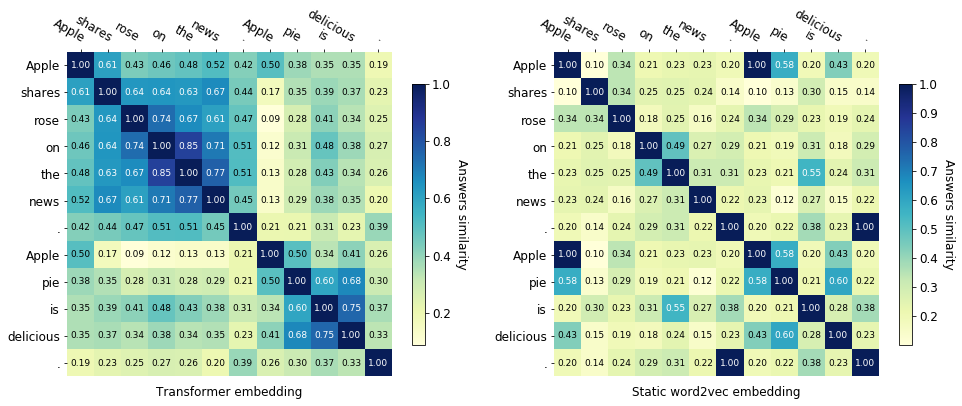

In [88]:
# Print pairwise distance of "Apple shares rose on the news. Apple pie is delicious."
m_tr1, t_tr1 = doc_to_tokens_vectors(doc_tr1)
m_st1, t_st1 = doc_to_tokens_vectors(doc_st1)
#plt.rcParams["figure.figsize"] = (8,8)
plt.rc('font', size=12)
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(16, 16))
ax1.set_xlabel('Transformer embedding')
ax2.set_xlabel('Static word2vec embedding')
fig, ax1 = print_heatmap(m_tr1, t_tr1, t_tr1, size=9, ax=ax1)
fig, ax2 = print_heatmap(m_st1, t_st1, t_st1, size=9, ax=ax2)

## Course_429

Here we try to test how the pretraind transformer model **BERT** works on the simple task of semantic similarity finding. For testing we use data from **Course_429** file.


In [181]:
def print_resps(data=eval_data, row=1, resp1="St_resp1", resp2="Pr_resp1"):
    assert row in data.index, "row should be one from list [3, 10, 17, 18, 19, 25, 27]"
    df = data.loc[row]
    print(resp1)
    print("#"*10)
    for r in df[resp1]:
        print(r['value'])
    print(resp2)
    print("#"*10)
    for r in df[resp2]:
        print(r['value'])


In [186]:
eval_data.columns

Index(['Step_prompt', 'St_resp1', 'St_resp2', 'St_resp3', 'St_resp4',
       'St_resp5', 'Pr_resp1', 'Pr_resp2', 'Pr_resp3', 'Pr_resp4', 'Pr_resp5',
       'Unique_ans'],
      dtype='object')

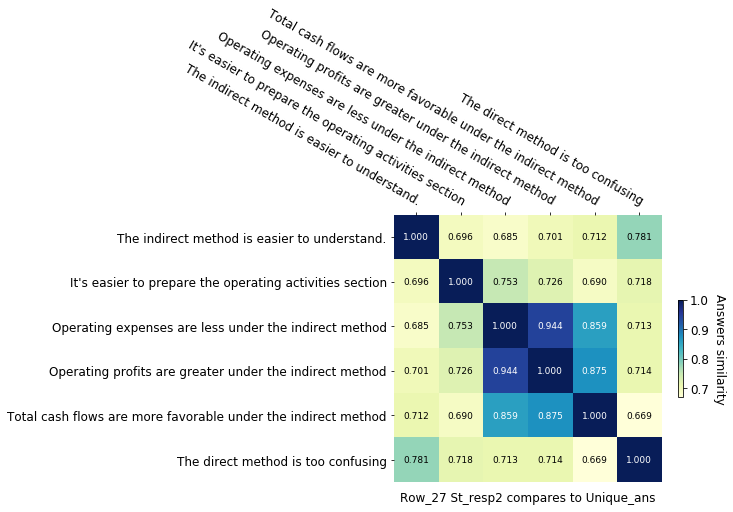

In [252]:
# !!!!row should be one from list [3, 10, 17, 18, 19, 25, 27] just to be easier to navigate for reference 
# file https://docs.google.com/spreadsheets/d/1o_aJjbZVqJ76DmHkZSkq5jXQwfOZ4fADz_l_grhAwwc/edit#gid=0!!!
# Columns differ a bit from the initial file, but easy to get correspondance.
# 'Step_prompt', 'St_resp1', 'St_resp2', 'St_resp3', 'St_resp4','St_resp5', 
# 'Pr_resp1', 'Pr_resp2', 'Pr_resp3', 'Pr_resp4', 'Pr_resp5', 'Unique_ans'
# Here you can change data to find similarities
Row = 27
Text1 = 'St_resp2'
Text2 = 'Unique_ans'
#
mat_1, tok_1 = docs_to_tokens_vectors(row=Row, text1=Text1, text2=Text2)
#plt.figure(figsize=(8, 8))
#plt.rc('font', size=14)
#fig, ax = print_heatmap(sim_matrix, tokens, tokens, size=12)
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('Row_' + str(Row)+ ' ' + Text1 + ' compares to ' + Text2)
fig, ax = print_heatmap(mat_1, tok_1, tok_1, size=9, ax=ax)

##  Challenges in NLP and possible solutions

Despite the recent achivements in NLP. Today exists many unsolved problems that requires almost human level reasoning. Let's concider the simple task, that any educated human is able to resolve without problem.

* **Question:** Why do stones fall to the ground?


1. **Wrong answer:** Stones have charge, therefore gravity acts on them
2. **True answer:** Stones have mass, therefore gravity acts on them
3. **True answer:** Object under the action of gravity force, strive to occupy a state with minimal energy
4. **Wrong answer:** Objects with electric charges attract stones

As we can see the answers 1 and 2 almost don't have any differnce apart of to words **charge** and **mass**. However this one word makes answer 1 completely wrong. At the same time the answer 3 is extremly good.

Model decides that answer 1 is similar to 2 and therefore is also true. It decides that way because it is inable to reason about phusics.

How can we try to solve the problem, knowing that the models with physics knowlege don't exist?

I suppose that at the moment the only solution to cope with such kind of problems is to use additional narrow contextual information from the field. The information potentially restrict the possible space of answers.
For example, if the model before trying to match all possible options, tries to find the answer on the question and looks for the all awailable information. There is a chance that there won't be any data about electrical charges and gravitation.  

### Using additional context

There are **transformer** based tools that allow to find answers in the given context. Let's make some experiments.
We need a newest **transformer==2.3.0**

```python
from transformers import pipeline
nlp = pipeline('question-answering')
# Now try to find answer on the question - "What range does gravity have?"

nlp(context="The gravitational attraction of the original gaseous matter present in the Universe caused it to begin coalescing, forming stars—and for the stars to group together into galaxies—so gravity is responsible for many of the large-scale structures in the Universe. Gravity has an infinite range, although its effects become increasingly weaker on farther objects.", question="What range does gravity have")

Converting examples to features: 100%|██████████| 1/1 [00:00<00:00, 91.26it/s]
{'answer': 'infinite', 'end': 284, 'score': 0.4511314237549797, 'start': 276}

# Answer is - 'infinite' that is true!!!

# Another more complicated question - "What caused the matter to begin coalescing"?
nlp(context="The gravitational attraction of the original gaseous matter present in the Universe caused it to begin coalescing, forming stars—and for the stars to group together into galaxies—so gravity is responsible for many of the large-scale structures in the Universe. Gravity has an infinite range, although its effects become increasingly weaker on farther objects.", question="What caused the matter to begin coalescing")

Converting examples to features: 100%|██████████| 1/1 [00:00<00:00, 82.22it/s]
{'answer': 'gravitational attraction of the original gaseous matter present in the Universe',
 'end': 83,
 'score': 0.21979344196318973,
 'start': 4}

# Answer is - 'gravitational attraction of the original gaseous matter present in the Universe'
# Also true

# Another question - "How gravitation affects farther objects?"

nlp(context="The gravitational attraction of the original gaseous matter present in the Universe caused it to begin coalescing, forming stars—and for the stars to group together into galaxies—so gravity is responsible for many of the large-scale structures in the Universe. Gravity has an infinite range, although its effects become increasingly weaker on farther objects.", question="How gravitation affects farther objects")

Converting examples to features: 100%|██████████| 1/1 [00:00<00:00, 149.47it/s]
{'answer': 'weaker', 'end': 339, 'score': 0.304665506045092, 'start': 333}

# Answer is - "weaker"
# that is pretty decent

nlp(context="Gravity is the weakest of the four fundamental interactions of physics, approximately 1038 times weaker than the strong interaction, 1036 times weaker than the electromagnetic force and 1029 times weaker than the weak interaction. As a consequence, it has no significant influence at the level of subatomic particles.[4] In contrast, it is the dominant interaction at the macroscopic scale, and is the cause of the formation, shape and trajectory (orbit) of astronomical bodies.", question="How much gravity is weaker than strong interaction")

Converting examples to features: 100%|██████████| 1/1 [00:00<00:00, 77.14it/s]
{'answer': '1029 times',
 'end': 196,
 'score': 0.14161941692760216,
 'start': 186}

# Answer is - '1029 times'
# That is right
```

It doesn't mean at all that the model knows the physics. All it can do, is just guess at what positions of the context's text can the answer be. But nevertheless, this information is very important for our application. 
The model is trainable, and we can train it using all available cources material.

I offer the following architecture of the semantic question-answer matching.

<img src="./QA_model.png" width="800" height="800">

Pic.1 Data flow in semantic question-answer matching

The core idea is to use for matching not only student's answer and predefined answers, but also **QuA model's** answer. Suchwise, we will not only inrease the performance of the matching model, but what is more important, we include the core model in the whole education process. Being able to answer questions the model has a chance to become an MI professor.

## NLP as service in production

Here are my thoughts how to organize NLP service at organization scale.

At the moment, it is clear, that at the core of NLP service should be the big **transformer** model. It was shown, that  transformers NLP performance scales linearly with the size of training data. It goes almost withought a sign of any plato. Thus, transformer models have a place to grow in the near future. 
Transformer models require substantial processing power to work. In production they run on the instances with GPU/TPU. The arcitecture, assumes that the main goal of transformer is to provide vector representation of the natural text messages.

Downstream tasks, such as; semantic matching, paraphrasing, question answering, dialogs, etc., may run on the more decent models that don't require much processing power. Downstream models may be implemented on any ML framework like Tensorflow, Pytorch and be running on the CPU instances.

Below is the blueprint of the proposed NLP infrastructure.

<img src="./NLP_infrastucture.png" width="400" height="400">

Pic.2 Data flow in NLP structure
